# Round One - EDA and Research
    This file contains a research of possible indicators for a profitable strat

#### 1. Extracting Data

In [38]:
ROUND = 1
ziputils.unzip(ROUND)

In [207]:
from Utils import Config, ziputils, dataUtils
from Utils.Algos import algo_mesoplodon_bowdoini
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

300
300


C:\Users\Ramon\AppData\Local\Temp\ipykernel_3560\2377702455.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["variance"] = (df["mid_price"].rolling(window).std()) ** 2
C:\Users\Ramon\AppData\Local\Temp\ipykernel_3560\2377702455.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["returns"] = df["mid_price"].pct_change(window)
C:\Users\Ramon\AppData\Local\Temp\ipykernel_3560\2377702455.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

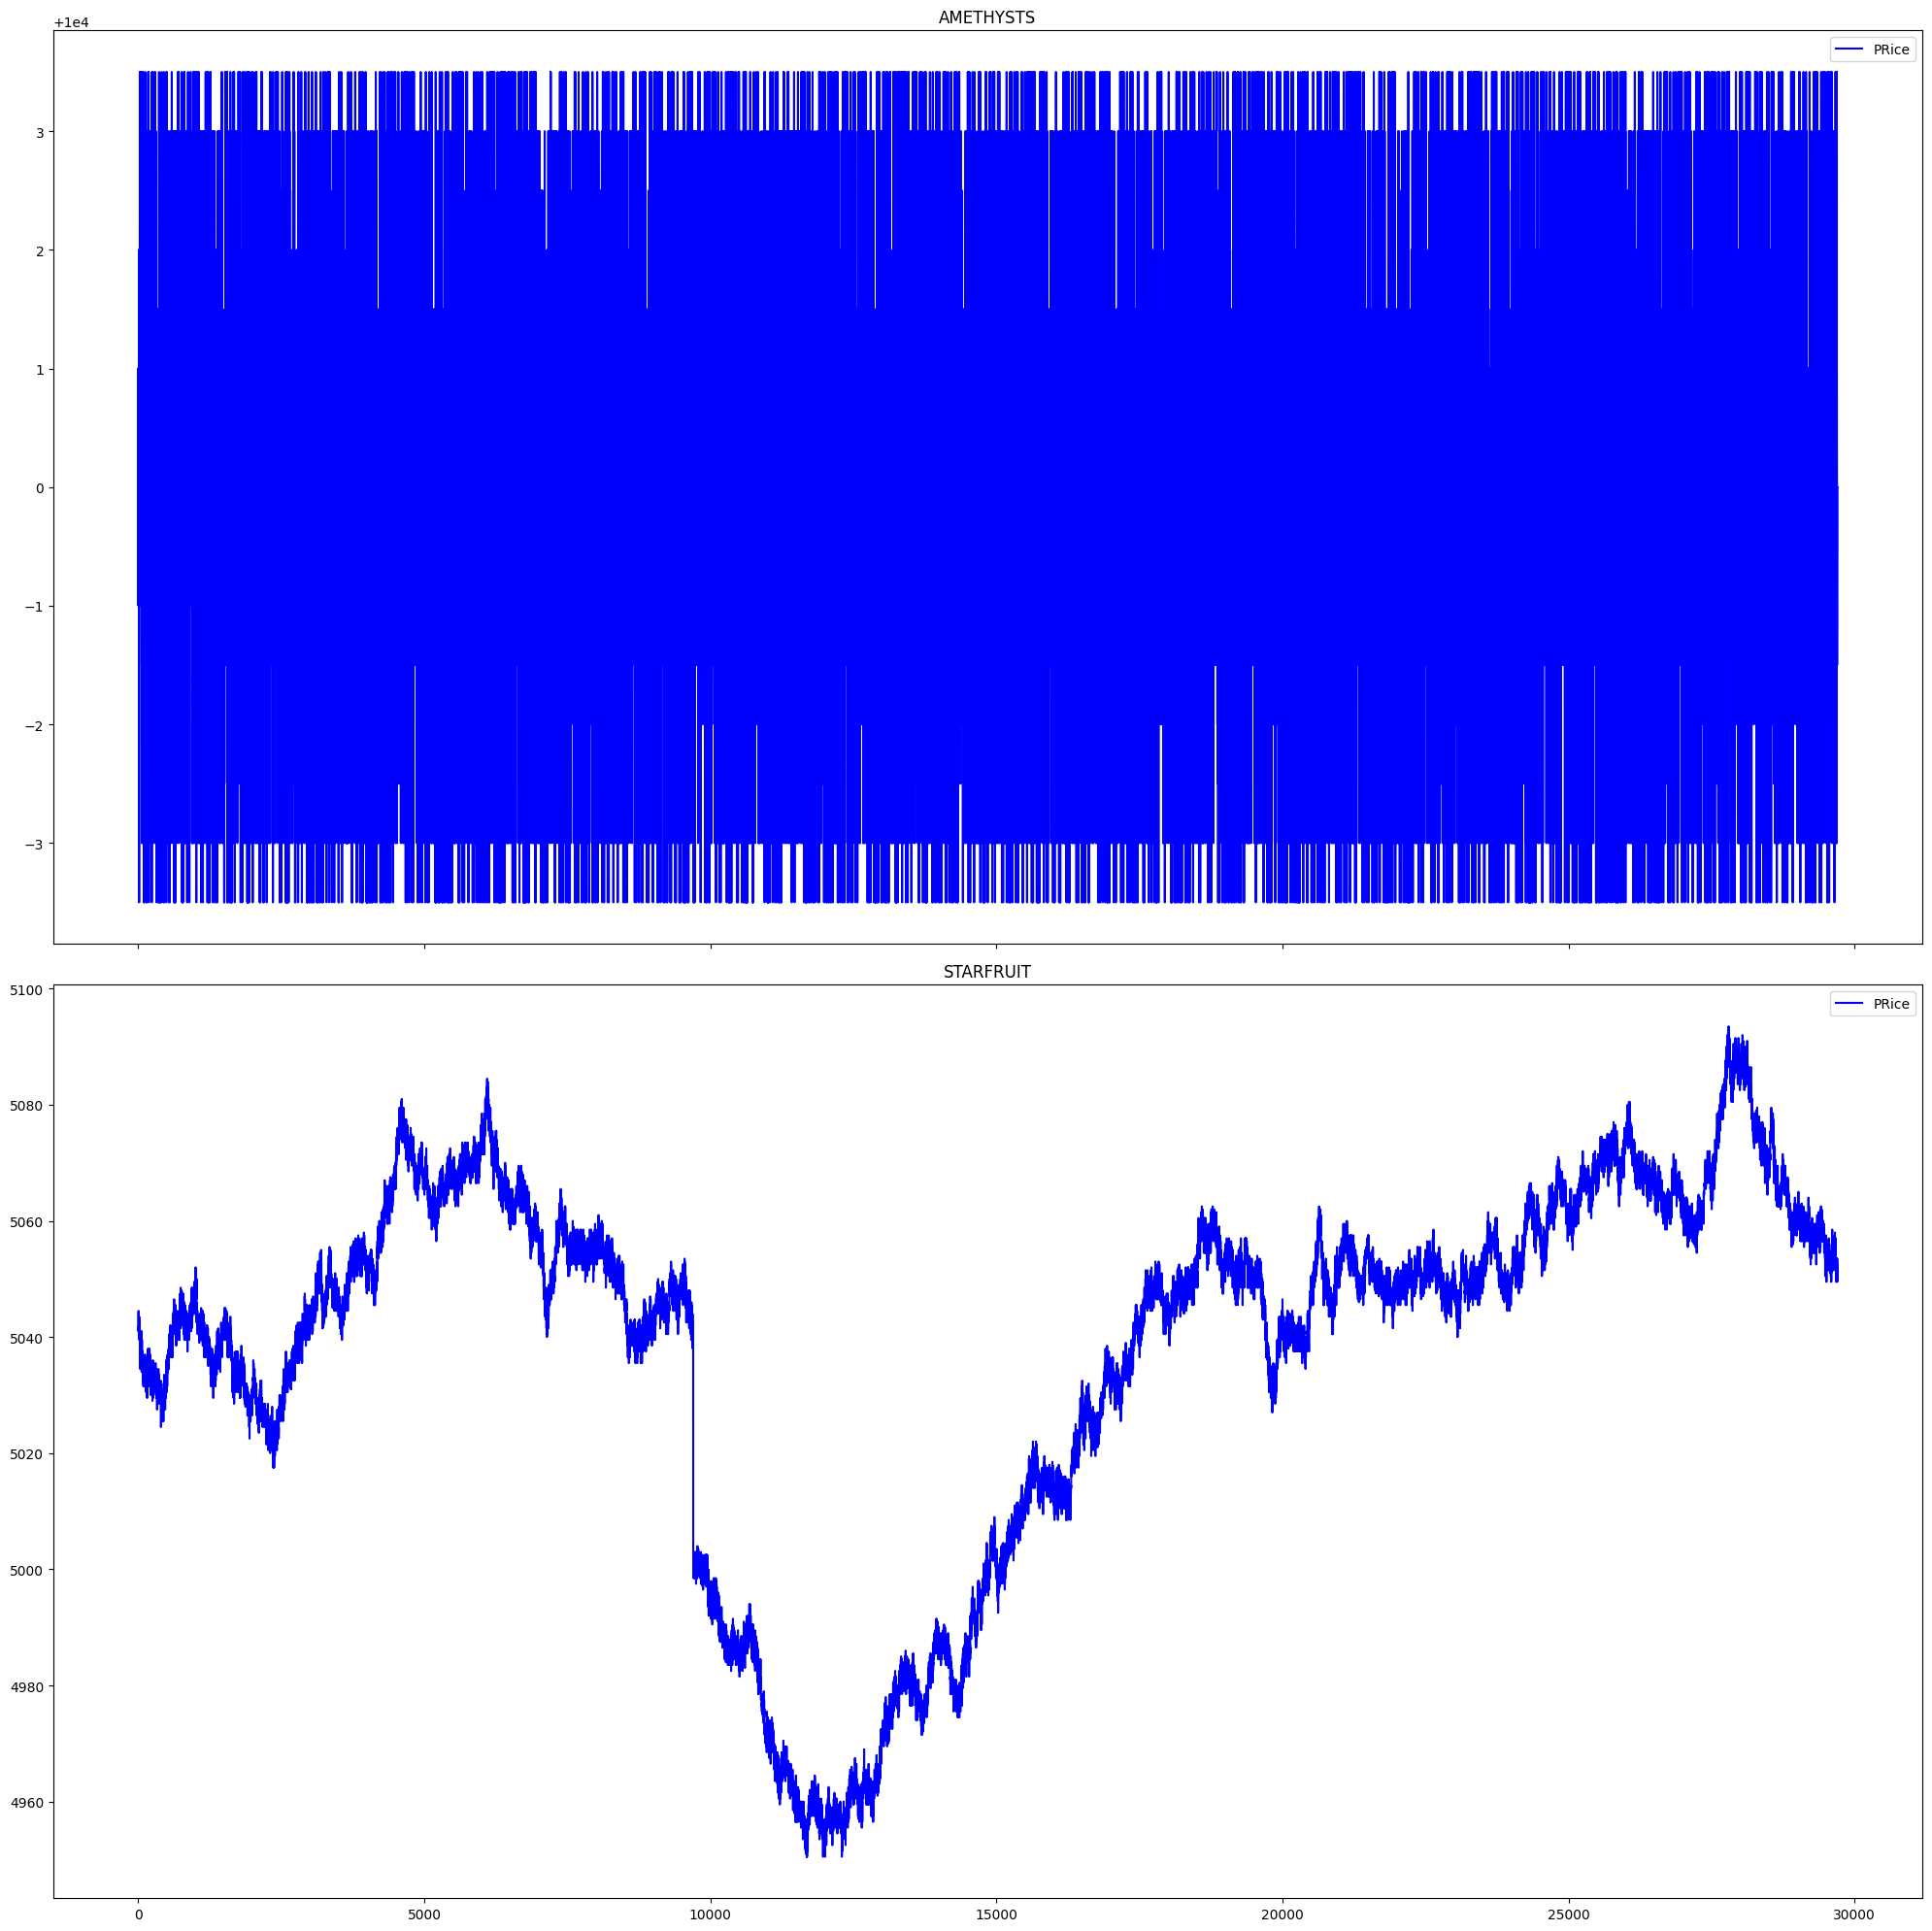

In [271]:
data = dataUtils.getDataPaths(1)

class MarketData:
    prices_df = dataUtils.concat_dfs("prices", data)
    trades_df = dataUtils.concat_dfs("trades", data)
    Products = list(prices_df["product"].unique())

    def construct_dfs():
        dfs_prices = {}
        for product in MarketData.Products:
            dfs_prices[product] = MarketData.prices_df[MarketData.prices_df["product"] == product]
        return dfs_prices
    
    def visualize_products(dfs):
        rows = len(dfs)
        fig, axs = plt.subplots(rows, sharex=True, figsize=(20, 10*rows))
        for ax, (product_name, df) in enumerate(dfs.items()):
            bid = df.bid_price_1
            ask = df.ask_price_1
            axs[ax].plot(df.mid_price, color="blue", label="PRice")
            axs[ax].set_title(product_name)
            axs[ax].legend()
        plt.tight_layout()
        plt.show()

    def buildFeatures(df):
        window = int(len(df) * 0.01)
        print(window)
        df["variance"] = (df["mid_price"].rolling(window).std()) ** 2
        df["returns"] = df["mid_price"].pct_change(window)
        df.drop(df.index[0:window], inplace = True)

    def constructFeatures(dfs):
        for product in MarketData.Products:
            MarketData.buildFeatures(df:=dfs[product])
            df.reset_index(inplace=True)

    def visualize_feats(df, features):
        n_features = len(features)
        fig, axs = plt.subplots(n_features, figsize=(20, n_features*2),sharex=True)
        for i, feature in enumerate(features):
            if "volume" in feature:
                axs[i].plot(df[feature], color = "c")
            else:
                axs[i].plot(df[feature], color = "c")
            axs[i].set_title(feature)
   
    def feature_corr(df, main_feats):
        fig = plt.figure(figsize=(10, 5))
        sns.heatmap(df[main_feats].corr())

dfs = MarketData.construct_dfs()
MarketData.constructFeatures(dfs)
MarketData.visualize_products(dfs)

#### Explore Features

- AMETHYSTS

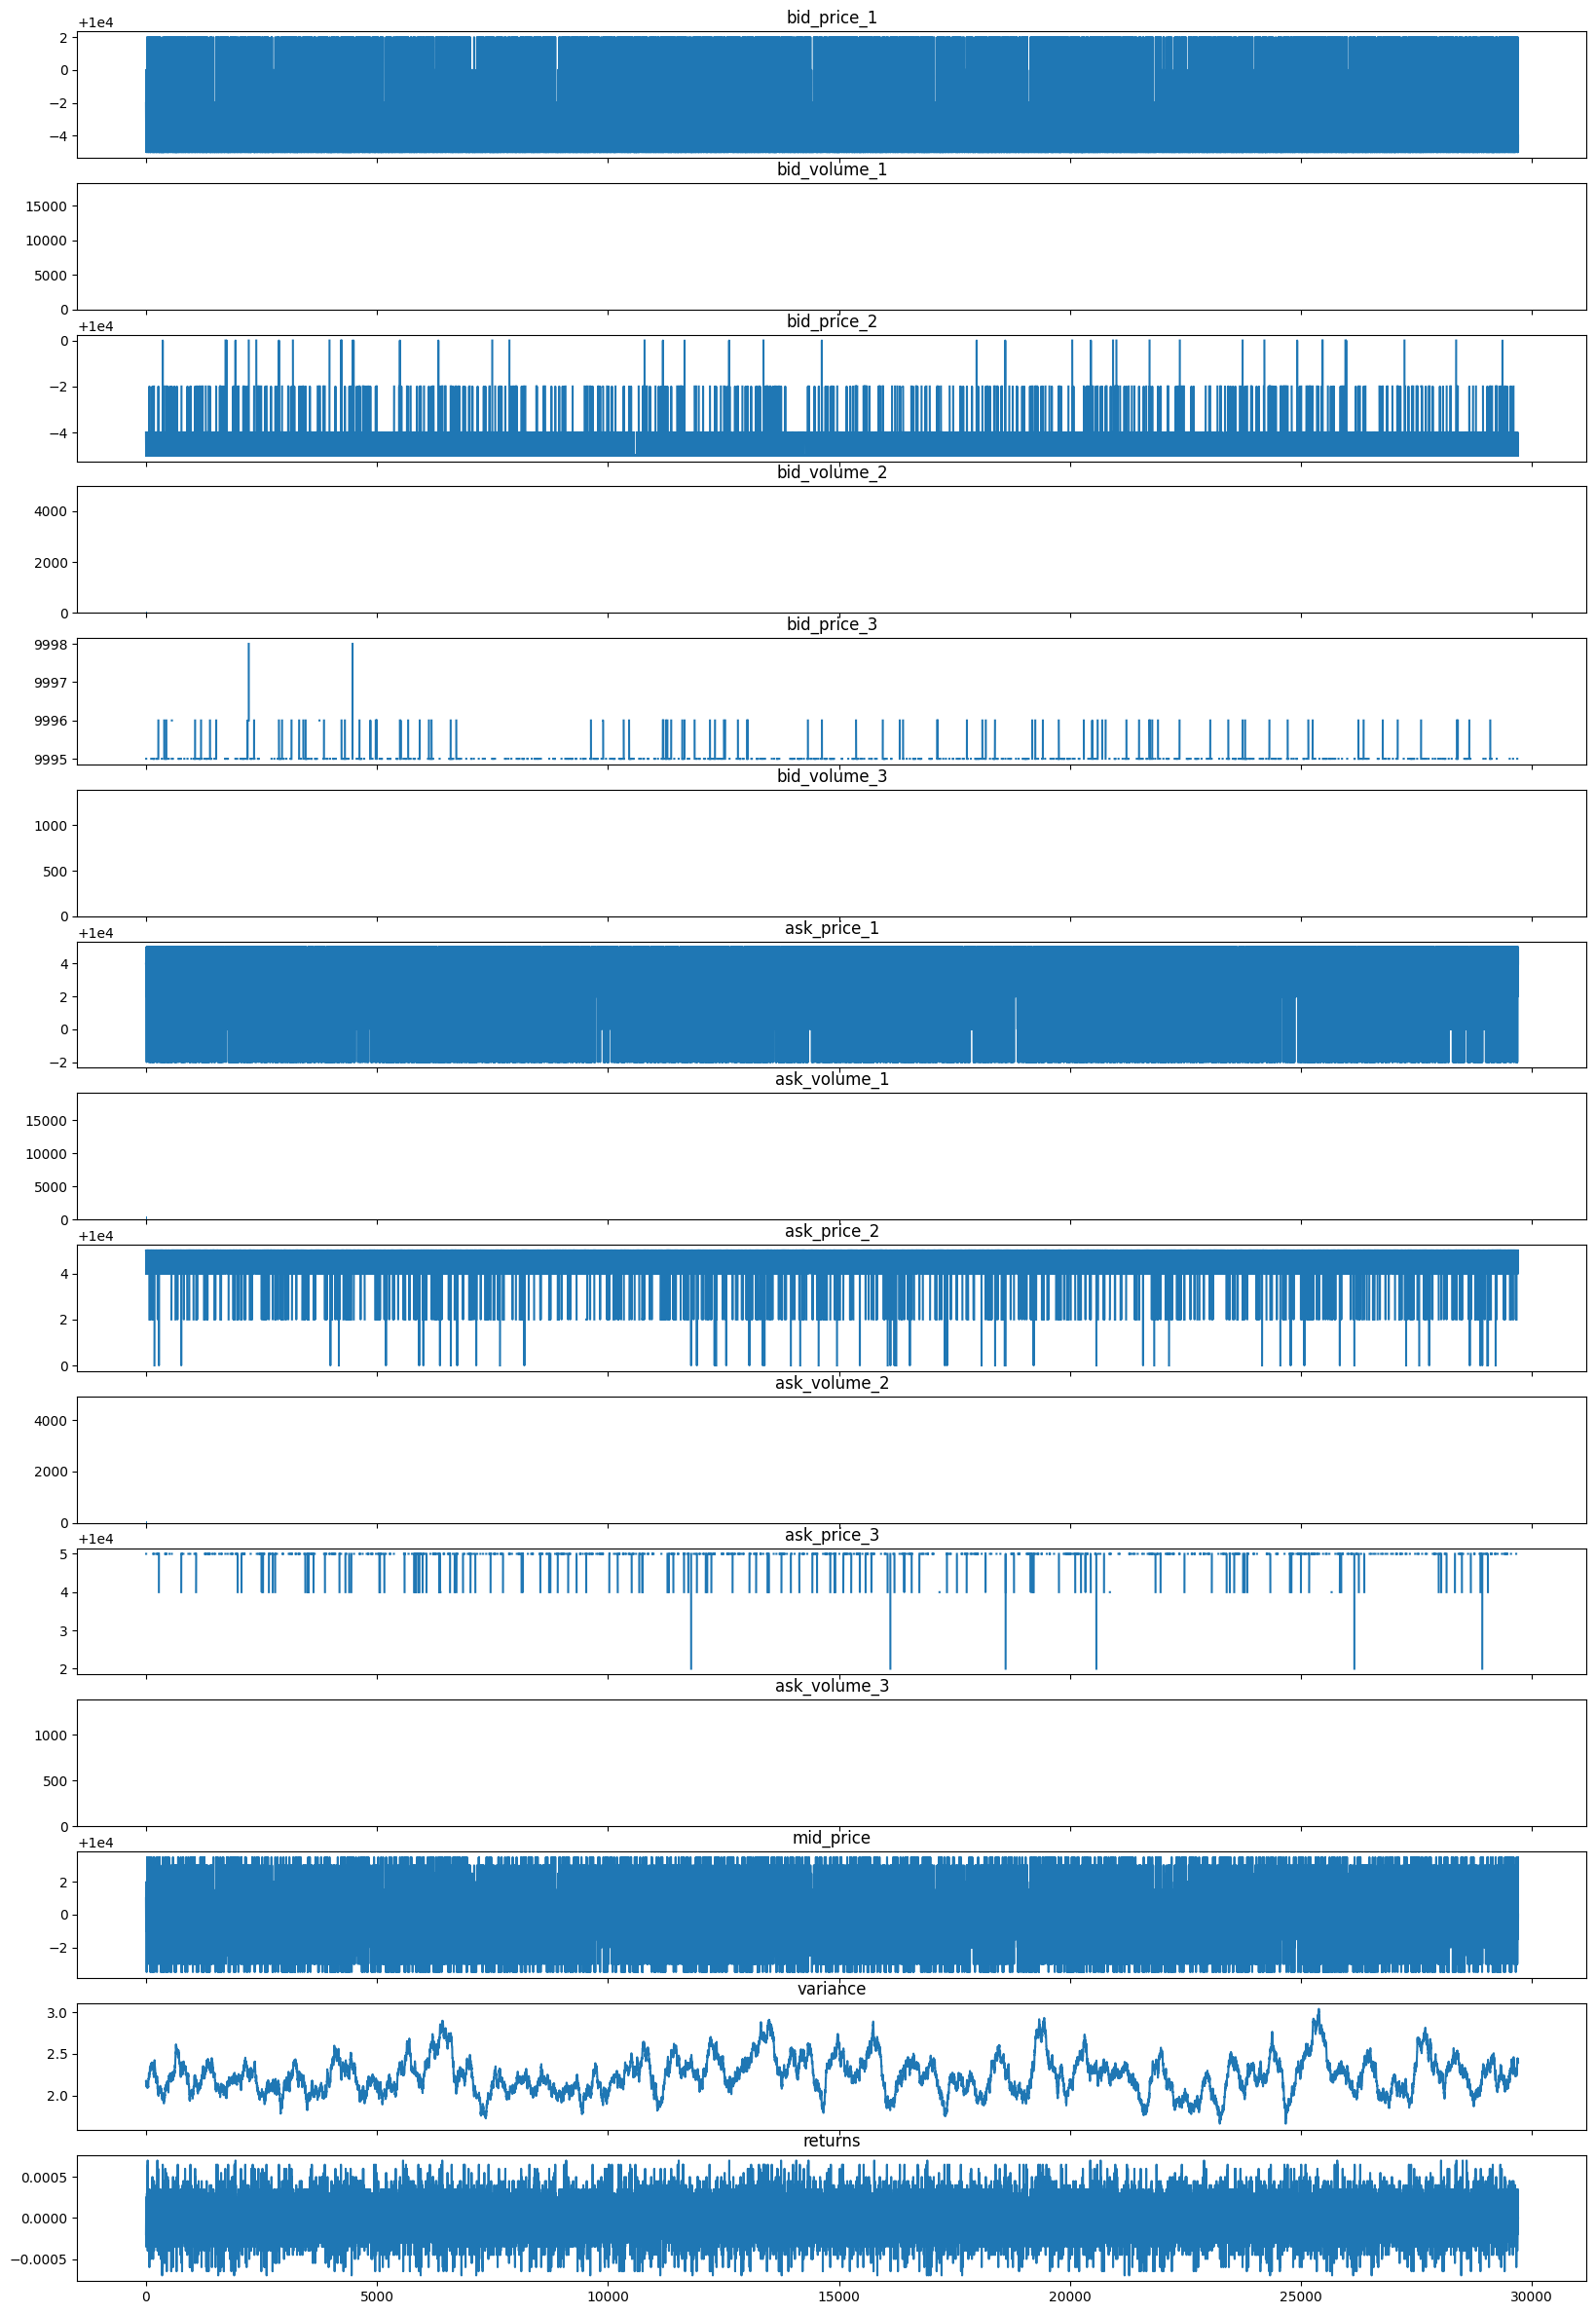

In [358]:
amethysts = dfs["AMETHYSTS"]
exclude_feats = ["index", "day", "timestamp", "product", "profit_and_loss"]
features = [i for i in amethysts.columns if i not in exclude_feats]
n_features = len(features)

fig, axs = plt.subplots(n_features, figsize=(20, n_features*2),sharex=True)
for i, feature in enumerate(features):
    if "volume" in feature:
        axs[i].hist(amethysts[feature])
    else:
        axs[i].plot(amethysts[feature])
    axs[i].set_title(feature)

- STARFRUIT

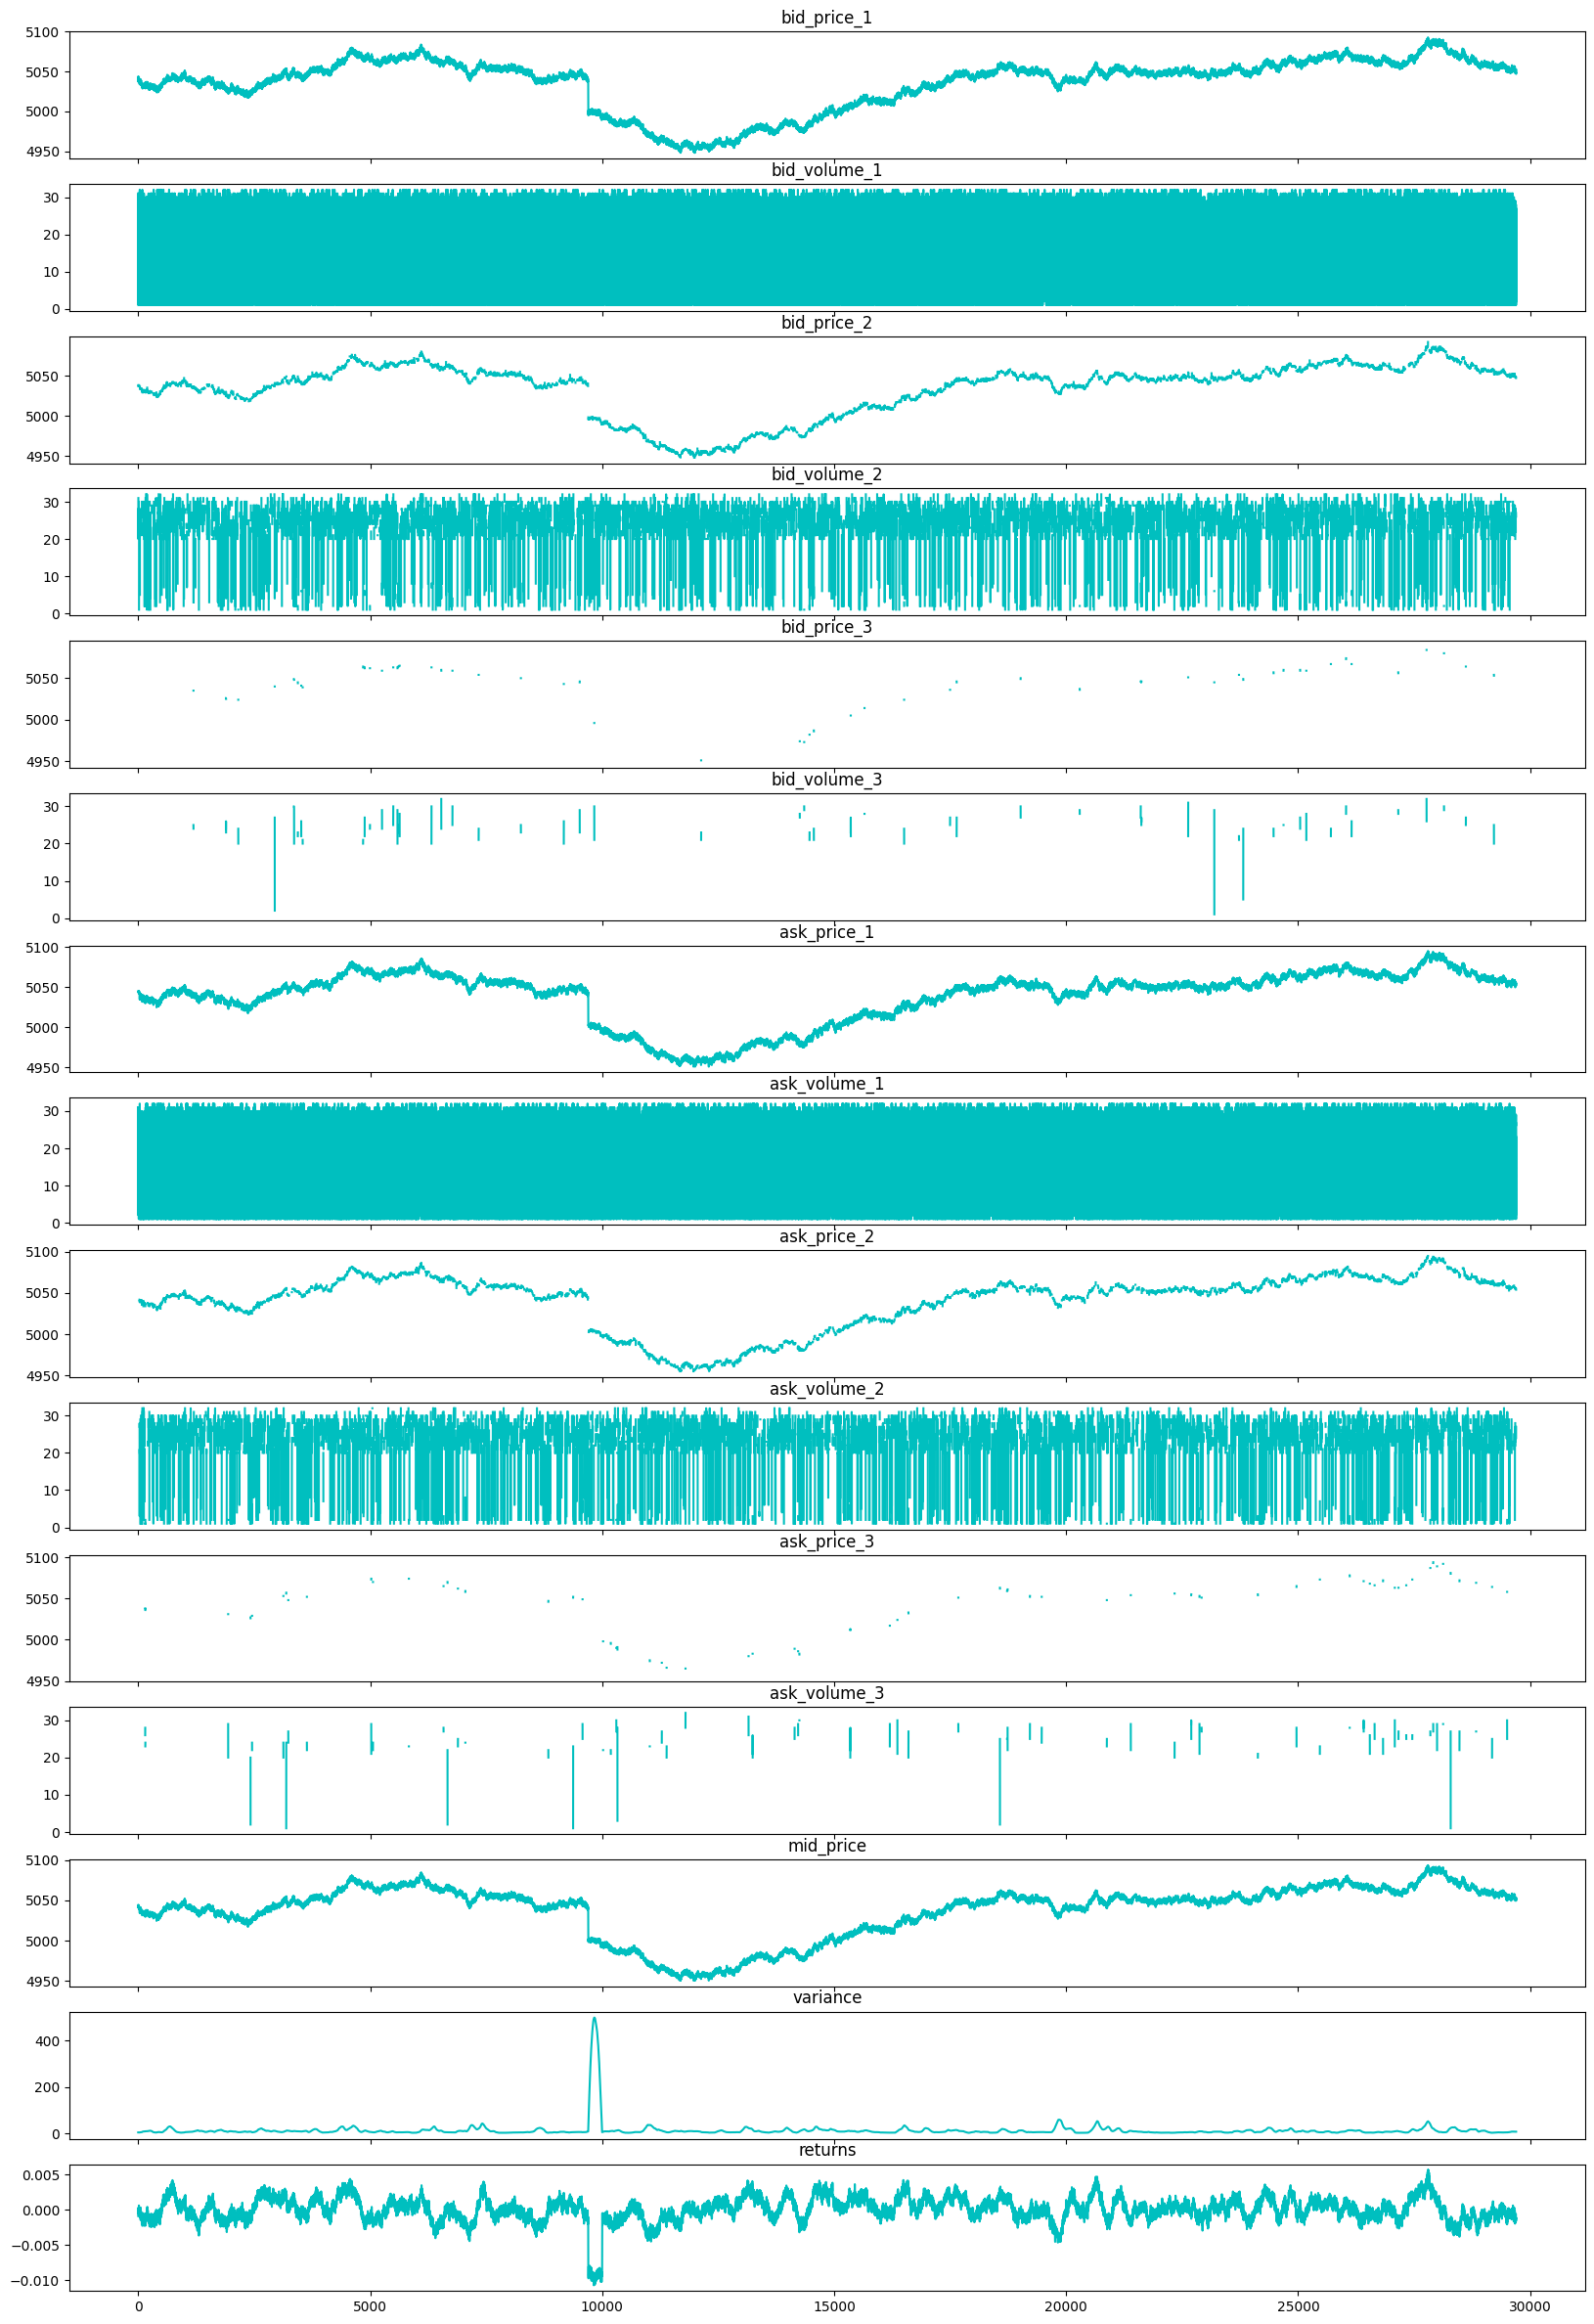

In [359]:
starfruit = dfs["STARFRUIT"]
features = [i for i in starfruit.columns if i not in exclude_feats]
n_features = len(features)

fig, axs = plt.subplots(n_features, figsize=(20, n_features*2),sharex=True)
for i, feature in enumerate(features):
    if "volume" in feature:
        axs[i].plot(starfruit[feature], color = "c")
    else:
        axs[i].plot(starfruit[feature], color = "c")
    axs[i].set_title(feature)

> Comment : for a mean reverting strategy only some bid ask levels add information without noise. Therefore we will avoid using depth level 1 and limit level 2 to avoid adding noise to our system. Now we will search for key movements in volatility to see what happened at level 3 and 2 before significant price movements. The idea is to add some measure of volatility where to trade.

In [523]:

df_sf = starfruit[main_feats]
df_am = amethysts[main_feats]
df_sf["predictions"] = df_sf["mid_price"]
df_am["predictions"] = df_am["mid_price"]
main_feats = [i for i in df_sf.columns if (("predictions" in i) or ("_3" in i and i not in exclude_feats) or (("variance" in i) or ("mid_price" in i)))]
noise_feats = [i for i in df_sf.columns if (i not in main_feats and i not in exclude_feats)]


df_sf.bfill(inplace=True)
df_sf.fillna(df_sf.mean(),inplace=True)
df_am.bfill(inplace=True)
df_am.fillna(df_am.mean(),inplace=True)

print(main_feats)

KeyError: "['predictions'] not in index"

#### Approximate function of returns with level 3 data

In [524]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [536]:
cutoff = 0.80
y = "mid_price"
p = "predictions"
r = "returns"
X = [i for i in main_feats if (i not in [r,p,y])]

print(X)

ts_df_sf = scaler.fit_transform(df_sf)
ts_df_am = scaler.fit_transform(df_am)

train_sf = pd.DataFrame(ts_df_sf[:int(len(ts_df_sf)*cutoff)], columns=main_feats)
test_sf = pd.DataFrame(ts_df_sf[int(len(ts_df_sf)*cutoff):], columns=main_feats)
sf_y_train = train_sf[y]
sf_X_train = train_sf[X]
sf_y_test = test_sf[y]
sf_X_test = test_sf[X]

train_am = pd.DataFrame(ts_df_am[:int(len(ts_df_am)*cutoff)], columns=main_feats)
test_am = pd.DataFrame(ts_df_am[int(len(ts_df_am)*cutoff):], columns=main_feats)
am_y_train = train_am[y]
am_X_train = train_am[X]
am_y_test = test_am[y]
am_X_test = test_am[X]


['bid_price_3', 'bid_volume_3', 'ask_price_3', 'ask_volume_3', 'variance']


['bid_price_3', 'bid_volume_3', 'ask_price_3', 'ask_volume_3', 'variance', 'returns']
-> MSE = 0.013234724902140274
 
    MID_PRICE (y) = 
    0.5082 * bid_price_3
    0.0041 * bid_volume_3
    0.4647 * ask_price_3
    -0.0041 * ask_volume_3
    0.001 * variance
    


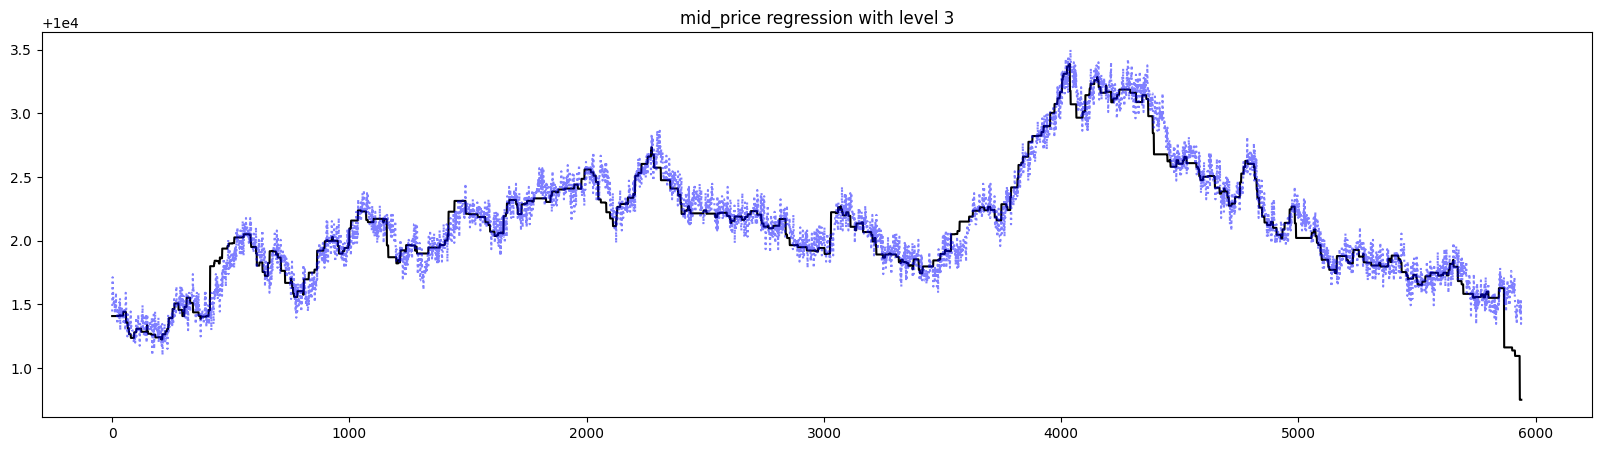

In [542]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(sf_X_train, sf_y_train)

sf_y_pred = model.predict(sf_X_test)
test_sf["predictions"] = sf_y_pred
inverse_sf = pd.DataFrame(scaler.inverse_transform(test_sf), columns=test_sf.columns)
inverse_sf_preds = inverse_sf["predictions"]
real_mid_price = inverse_sf["mid_price"]

fig = plt.figure(figsize=(20,5))
plt.plot(inverse_sf_preds, color="black")
plt.plot(real_mid_price, color="blue", linestyle="dotted", alpha=0.50)
plt.title("mid_price regression with level 3")
plt.savefig(f"{Config.CHARTS_DIR}/SF_predict_mid_price_R1.jpg")

model_coefs = np.round(model.coef_, 4)
print(params)

print(
    f"-> MSE = {mean_squared_error(inverse_sf_preds, real_mid_price)}\n",
    f"""
    MID_PRICE (y) = 
    {model_coefs[0]} * {X[0]}
    {model_coefs[1]} * {X[1]}
    {model_coefs[2]} * {X[2]}
    {model_coefs[3]} * {X[3]}
    {model_coefs[4]} * {X[4]}
    """

)